# Miguel López Vélez cc 1001014378
# Andres Ruiz cc 1007448685

Proyecto 2 Bioseñales y sistemas

Objetivos:

-Aprender a usar Python para la manipulación y visualización básica de señales

-Programar operaciones matemáticas sobres señales

-Hacer comparaciones e inferencias sobre conjuntos de datos


In [8]:
#libreria para manejo de NDARRAY
import numpy as np;
import scipy as sp
#libreria para graficar
import matplotlib.pyplot as plt
#Lector de archivos csv
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym
import pandas as pd
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import pingouin as pg
from scipy.signal import welch as pwelch

In [9]:
ruta_carpeta = '../control'

# Obtener la lista de archivos en la carpeta
lista_archivos = os.listdir(ruta_carpeta)

# Crear una matriz vacía para almacenar los datos
datos_matriz = [] # num_columnas es el número de columnas en los datos

# Iterar a través de cada archivo y agregar los datos a la matriz
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_matriz.append(data)

ruta_carpeta = '../parkinson'
lista_archivos = os.listdir(ruta_carpeta)
datos_parkinson=[]
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_parkinson.append(data)
print("Todo cargado")

Todo cargado


# Punto 2
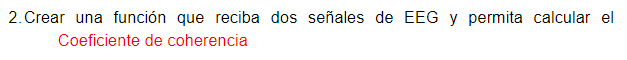

In [10]:
def coherence(data1,data2):
    X = np.fft.fft(data1)
    Y = np.fft.fft(data2)
    sxy = X * Y.conjugate()
    sxx = X * X.conjugate()
    syy = Y * Y.conjugate()
    return np.abs(np.mean(sxy.real))/np.sqrt(np.mean(sxx.real)*np.mean(syy.real))
#Nótese que en la ecuación cuando hablamos de la misma señal el n se torna como el numero de puntos así que se puede traducir en el promedio

In [11]:
coherence(datos_matriz[0][0][0],datos_matriz[0][0][0])

1.0

In [12]:
coherence(datos_matriz[0][1][0],datos_matriz[0][0][0])

0.7224334844699055

# Punto 3
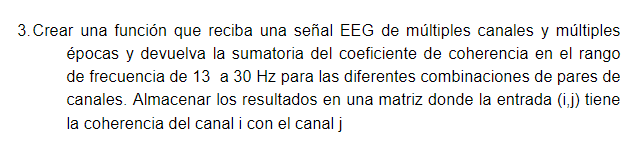

In [13]:
def coherence_matrix(data, fs):
    n_channels, n_samples ,n_epochs,  = data.shape
    
    # Definir los límites de frecuencia para calcular la coherencia
    fmin = 13
    fmax = 30
    
    # Calcular el índice de las frecuencias correspondientes
    freqs = np.fft.fftfreq(n_samples, 1/fs)
    idx_band = np.where((freqs >= fmin) & (freqs <= fmax))[0]
   
    # Inicializar la matriz de coherencia
    coh_matrix = np.zeros((n_channels, n_channels))
    
    # Calcular la coherencia para cada par de canales
    for i in range(n_channels):
        for j in range(n_channels):
            #Se inician vectores en 0 para cada par de operaciones ya que al ser el calculo en épocas y lo que nos interesa es una 
            #sumatoria de las frecuencias es más rápido por este medio
            sum_sxy= np.zeros(len(idx_band))
            sum_sxx= np.zeros(len(idx_band))
            sum_syy= np.zeros(len(idx_band))
            for k in range(n_epochs):
                #Se toman los puntos por cada época
                x = data[i, : , k]
                y = data[j, :, k]
                #Se saca la transformada en la epoca
                X = np.fft.fft(x)
                Y = np.fft.fft(y)
                #Se generan los vectores con el rango en especifico
                sxy = X[idx_band] * Y[idx_band].conjugate()
                sxx = X[idx_band] * X[idx_band].conjugate()
                syy = Y[idx_band] * Y[idx_band].conjugate()
                #Se suman los vectores a los anteriores para cumplir con la sumatoria a lo largo de las épocas 
                sum_sxy+=sxy.real
                sum_sxx+=sxx.real
                sum_syy+=syy.real
            #Con los vectores de sumatoria en la época se aplican las operaciones de la ecuación
            coh_sum=np.abs(sum_sxy/n_epochs)/np.sqrt(sum_sxx*sum_syy/(n_epochs**2))
            #Finalmente se suman los puntos de los vectores 
            coh_matrix[i, j] = np.sum(coh_sum) 
            
    return coh_matrix

In [14]:
a=coherence_matrix(datos_matriz[0],1000)
#print(aaa) # idx_band

In [15]:
df=pd.DataFrame(a) 
df

,0,1,2,3,4,5,6,7
0,35.000000,27.158471,9.494119,6.862532,15.858306,2.677902,7.541589,11.835994
1,27.158471,35.000000,25.844251,7.023974,7.602380,8.530986,12.622465,14.833776
2,9.494119,25.844251,35.000000,22.915743,6.583487,13.226007,14.876855,14.194794
3,6.862532,7.023974,22.915743,35.000000,27.385674,14.519833,13.343328,9.591165
4,15.858306,7.602380,6.583487,27.385674,35.000000,12.373601,9.186112,4.268638
5,2.677902,8.530986,13.226007,14.519833,12.373601,35.000000,32.126576,19.497182
6,7.541589,12.622465,14.876855,13.343328,9.186112,32.126576,35.000000,27.554583
7,11.835994,14.833776,14.194794,9.591165,4.268638,19.497182,27.554583,35.000000


# Punto 5
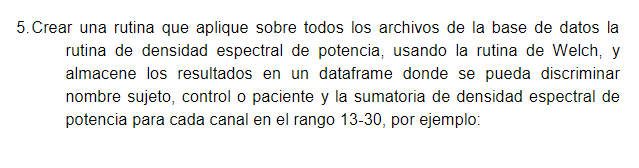

In [16]:
def PSD(data):
    fs=1000
    nperseg=2000
    noverlap=(nperseg//2)
    
    Tn=nperseg/fs
    fmin=int(13*Tn)
    fmax=int((30*Tn)+1)
   
    _,Pxx=pwelch(data,fs,"hamming",nperseg=nperseg,noverlap=noverlap)
    x=Pxx[fmin:fmax]
    
    return np.sum(x)


In [17]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
"""Se crea rutina con ciclos anidados para recorrer la matriz de pacientes y los canales de cada uno de estos"""

for i in r:
    promcanales=["Control"]
    x=datos_matriz[i]
    senal_continua = np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]),order='F')
    for canales in senal_continua:
        canal=PSD(canales)
        promcanales.append(canal)
    datosprompaciente.append(promcanales)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))

for i in r:
    promcanales=["Parkinson"]
    x=datos_parkinson[i]
    senal_continua = np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]),order='F')
    for canales in senal_continua:
        canal=PSD(canales)
        promcanales.append(canal)
    datosprompaciente_p.append(promcanales)

In [18]:
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2'] #Los nombres de las columnas

In [19]:
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
#Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente 
# (lista con primedio de cada canal) y el contador para identificar el paciente
for paciente in datosprompaciente: 
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
Sujeto,,,,,,,,,
1,Control,9.062152,8.187032,8.209503,7.149991,7.953234,9.557815,7.621705,9.341435
2,Control,4.541114,4.474356,5.268274,5.377385,5.013520,14.985470,11.236807,12.328471
3,Control,4.525821,3.312598,5.547753,2.668167,5.553965,3.377261,3.464131,4.726387
4,Control,11.434981,8.564256,8.877882,8.869631,12.035870,18.066870,16.868238,18.372696
5,Control,7.792090,8.061644,8.008805,8.352176,8.866972,13.294795,9.861908,10.922841
6,Control,5.044943,4.180159,4.877620,4.267487,4.827144,5.678989,5.646178,6.722588
7,Control,4.117968,3.954962,4.620961,4.031215,4.445918,5.168547,4.037755,6.512078
8,Control,5.654712,3.725324,3.993182,3.987941,6.883226,8.159307,6.174555,7.206216
9,Control,1.857686,1.737646,2.003545,1.862828,2.005269,8.649002,8.559307,9.184750


In [20]:
df.to_csv("Tabla.cvs",index=False)

In [21]:
df=pd.read_csv("Tabla.cvs")

# Punto 4
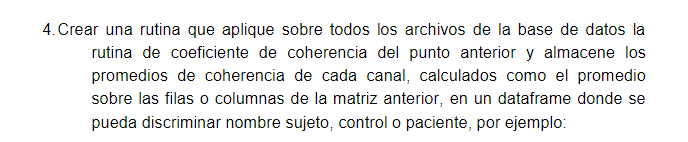

In [22]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
"""Se crea rutina con ciclos para recorrer la matriz de pacientes"""

for i in r:
    promcanales="Control"
    x=coherence_matrix(datos_matriz[i],1000)
    x=x.mean(0).tolist()
    x.insert(0,promcanales)
    datosprompaciente.append(x)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))

for i in r:
    promcanales="Parkinson"
    x=coherence_matrix(datos_matriz[i],1000)
    x=x.mean(0).tolist()
    x.insert(0,promcanales)
    datosprompaciente_p.append(x)

In [23]:
namesc = ["Estado",'Coh_C3', 'Coh_C1', 'Coh_CZ', 'Coh_C2', 'Coh_C4', 'Coh_O1', 'Coh_OZ', 'Coh_O2'] #Los nombres de las columnas

In [24]:
df=pd.DataFrame(columns=namesc) #Se crea el data frame
con=1 
#Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente 
# (lista con primedio de cada canal) y el contador para identificar el paciente
for paciente in datosprompaciente: 
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,Coh_C3,Coh_C1,Coh_CZ,Coh_C2,Coh_C4,Coh_O1,Coh_OZ,Coh_O2
Sujeto,,,,,,,,,
1,Control,14.553614,17.327038,17.766907,17.080281,14.782275,17.244011,19.031439,17.097017
2,Control,16.743210,21.139847,22.638254,21.293390,17.487544,21.888139,23.616915,22.059106
3,Control,21.153811,22.975754,22.349906,21.748414,22.318046,19.205083,21.304379,20.427635
4,Control,15.679078,19.772166,20.245217,19.296772,14.577410,19.785985,21.256705,19.999231
5,Control,16.143768,19.872700,21.147171,18.944445,15.212077,19.603350,21.416090,19.344375
6,Control,14.132686,16.506231,17.572053,17.065609,14.457549,16.924206,18.300402,17.407010
7,Control,14.530466,20.760944,22.146609,21.168574,15.481755,22.244769,19.189866,21.113584
8,Control,14.666671,17.151017,17.405649,17.474087,14.595465,16.454309,18.803429,16.924583
9,Control,16.541623,22.309434,23.311713,22.051210,17.844247,20.983615,22.630786,21.020140


In [25]:
df.to_csv("Tabla_coherencia.cvs",index=False)

---

# Estadística descriptiva PSD

Se leen las tablas anteriormente guardadas para evitar correr todas las rutinas cada vez

In [26]:
df=pd.read_csv("Tabla.cvs") #Datos de PSD
df2=pd.read_csv("Tabla_coherencia.cvs") #Datos de coherencia
df3=pd.read_csv("PSD_Tlog.cvs")

Se visualiza la diferencia entre los promedios

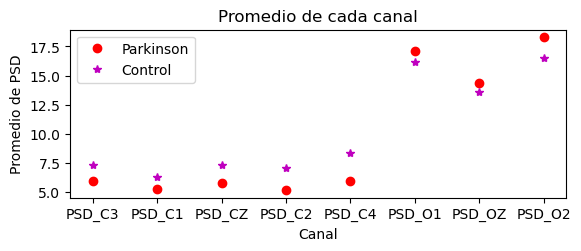

In [27]:
control,parkinson = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]
prom=[]
for i in control.columns[1:]:
    prom.append(control[i].mean())
promcontrol=pd.DataFrame(columns=control.columns[1:].to_list())
promcontrol.loc[0]=prom
prom=[]
for i in parkinson.columns[1:]:
    prom.append(parkinson[i].mean())
promparkinson=pd.DataFrame(columns=parkinson.columns[1:].to_list())
promparkinson.loc[0]=prom
plt.subplot(2,1,1)
plt.plot(promparkinson.loc[0], "or", linewidth='1',label="Parkinson" )
plt.plot(promcontrol.loc[0],"*m" , linewidth='1',label="Control" )
plt.title("Promedio de cada canal")
plt.ylabel("Promedio de PSD")
plt.xlabel("Canal")
plt.legend()

Se puede notar una diferencia entre los promedios de la sumatoria del PSD para las frecuecias de 13 a 30 Hz de los diferentes canales en pacientes parkinson y los pacientes control pero no se sabe si esta diferencia es significativa

Se visualiza la distribución con histogramas

In [28]:
def grafhist(data):
    con=1
    names=data.columns
    plt.figure(figsize=(15,8))
    plt.suptitle("Distribución de datos de "+data[names[0]][0])
    for i in names[1:]:
        plt.subplot(2,4,con)
        plt.hist(data[i],bins=8)
        plt.axvline(data[i].mean(),color="r",linestyle="dashed",linewidth=2)
        plt.title(i)
        con+=1

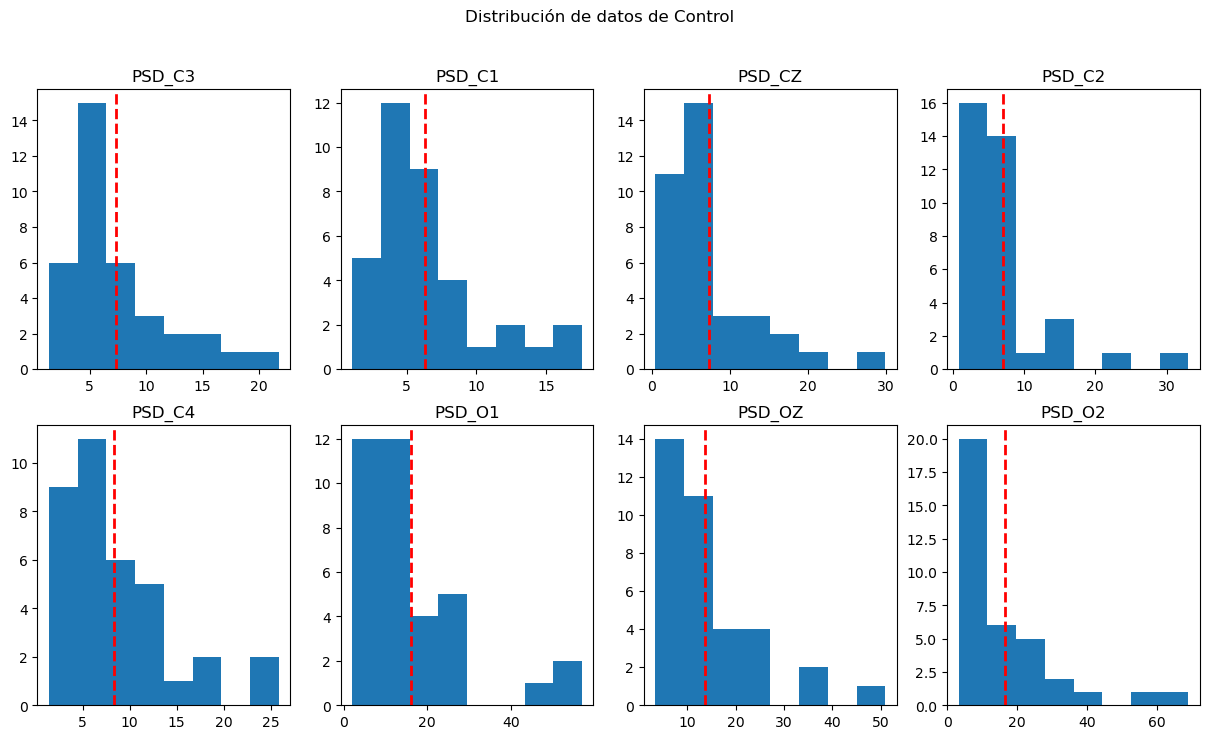

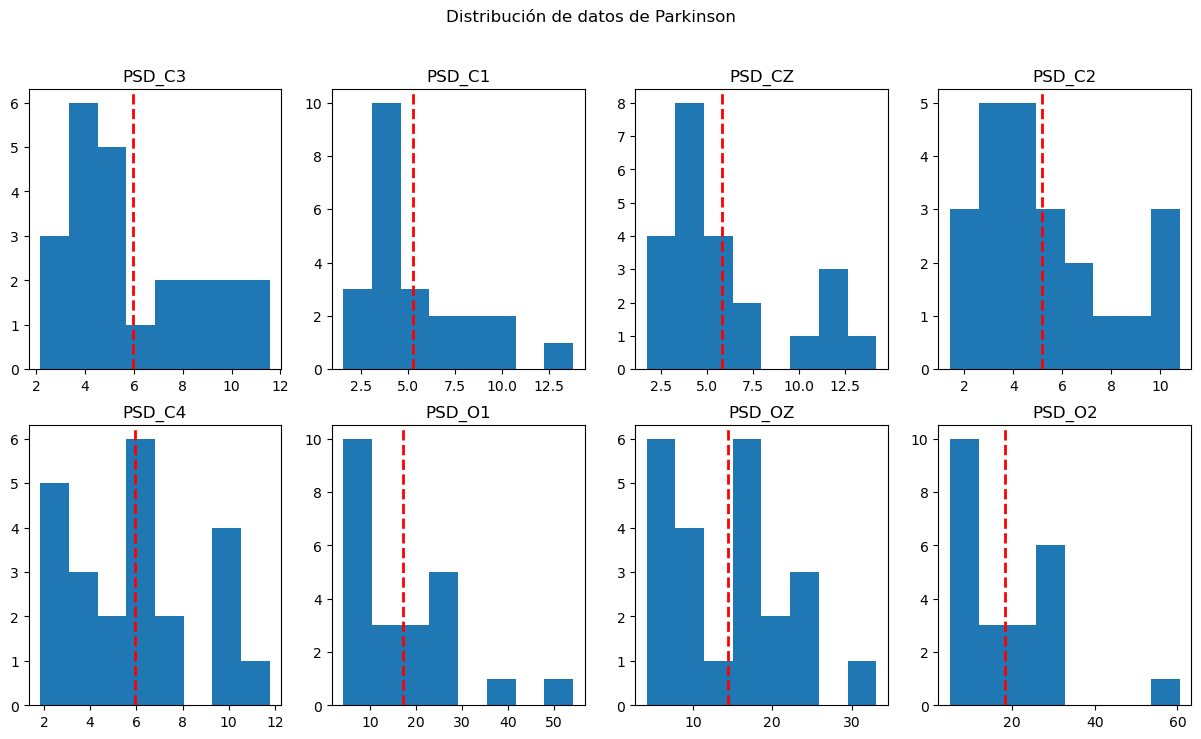

In [29]:
control,parkinson = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]
parkinson=parkinson.reset_index(drop=True)
names=control.columns
grafhist(control)
grafhist(parkinson)

Los datos no parecen seguir una distribución normal, requerida para realizar una prueba T

Se procede a visualizar mejor los datos con un diagrama de caja y bigotes el cual contiene la información de los gráficos anteriores y muestra la desviación

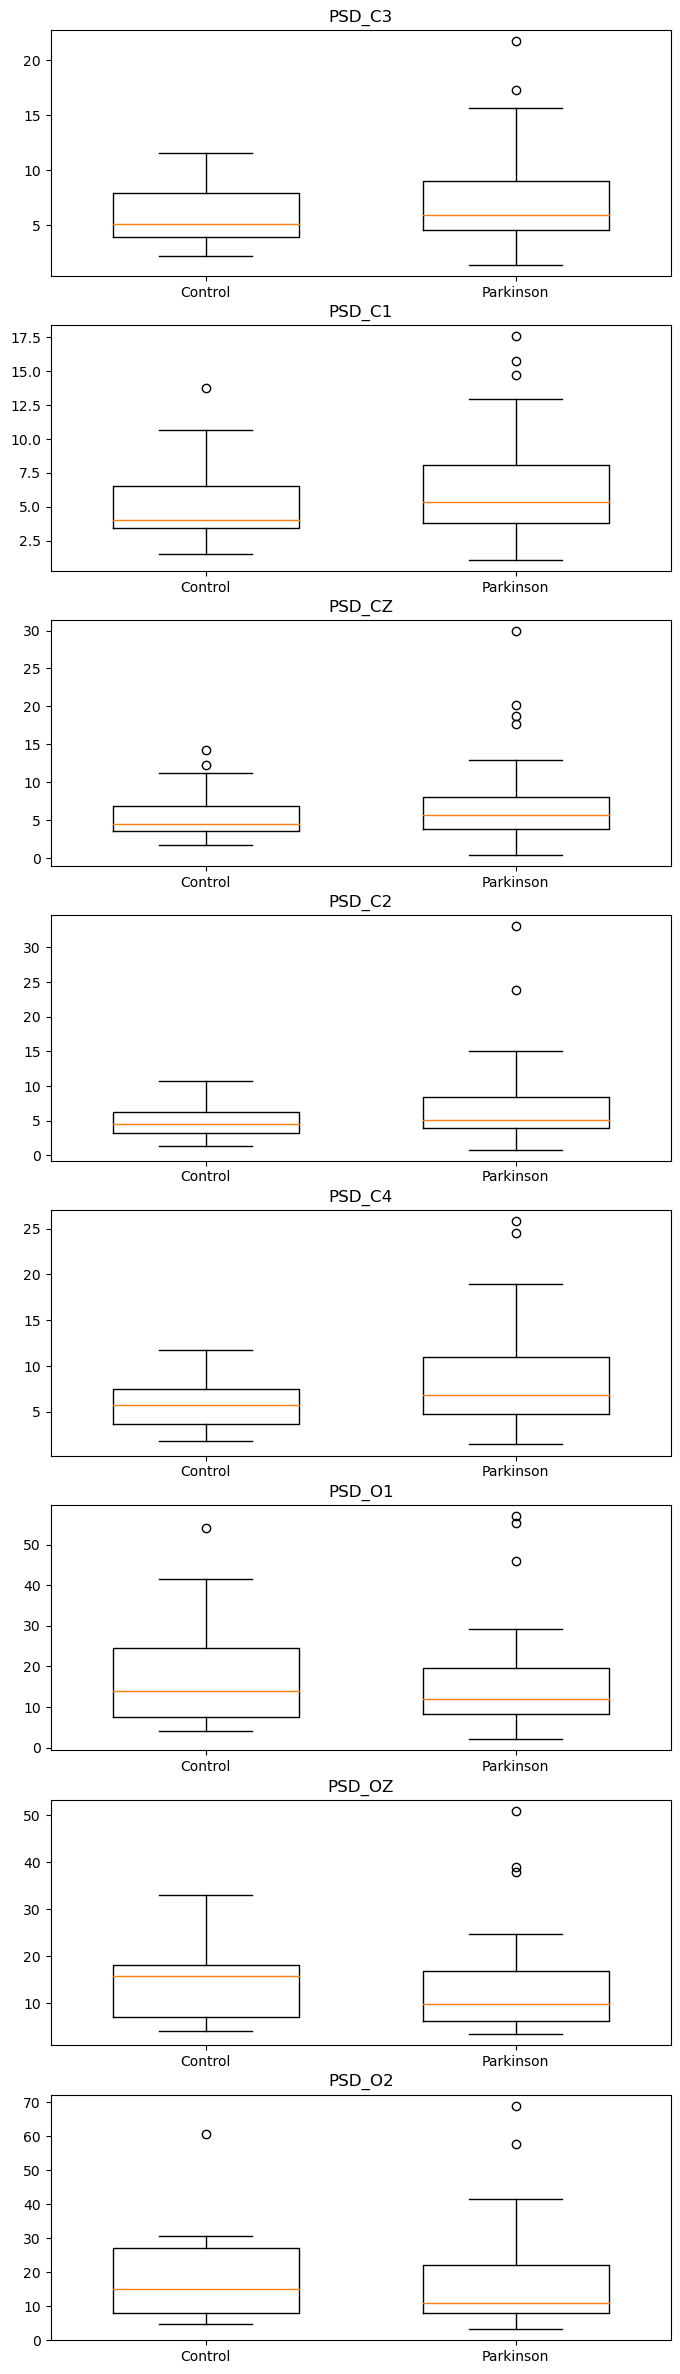

In [30]:
canales = ['PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2'] 

fig, axs = plt.subplots(len(canales), 1, figsize=(8, 30))

for i, canal in enumerate(canales):
    for estado in df['Estado'].unique():
        datos_canal_estado = df.loc[df['Estado'] == estado, canal]
        axs[i].boxplot(datos_canal_estado, positions=[0 if estado == 'Parkinson' else 1], widths=0.6)
        
        axs[i].set_title(canal)
    axs[i].set_xticklabels(['Parkinson', 'Control'])
plt.show()

In [31]:
dataframes = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]
# Cálculo de la media y la desviación estándar para cada canal
mean_parkinson = dataframes[1].select_dtypes(include=np.number).mean()
std_parkinson = dataframes[1].select_dtypes(include=np.number).std()

mean_control = dataframes[0].select_dtypes(include=np.number).mean()
std_control = dataframes[0].select_dtypes(include=np.number).std()

# Creación del dataframe con los resultados
df_results = pd.DataFrame({
    'Canal': mean_parkinson.index,
    'Media Parkinson': mean_parkinson.values,
    'Desv. Est. Parkinson': std_parkinson.values,
    'Media Control': mean_control.values,
    'Desv. Est. Control': std_control.values,
})

df_results

,Canal,Media Parkinson,Desv. Est. Parkinson,Media Control,Desv. Est. Control
0,PSD_C3,5.974858,2.792382,7.338246,4.599109
1,PSD_C1,5.273632,3.116116,6.325656,4.144918
2,PSD_CZ,5.785000,3.546743,7.332909,6.057312
3,PSD_C2,5.162807,2.800215,7.080957,6.465159
4,PSD_C4,5.954880,2.911959,8.359298,5.862602
5,PSD_O1,17.075360,12.561674,16.138638,13.264496
6,PSD_OZ,14.400776,7.864543,13.624426,10.786595
7,PSD_O2,18.281925,13.065904,16.496742,14.384994


Se tienen unas desviaciones estandar mayores a 2 que es un valor muy alto para una desviación estandar

---

# Estadistica inferencial

Se evalua normalidad con prueba de Shapiro-Wilk y Omnibus para ver si estos datos aplican para una prueba T.

In [32]:
def check_normality(data):

    pVals = pd.Series('p-value')
    # The scipy normaltest is based on D-Agostino and Pearsons test that
    # combines skew and kurtosis to produce an omnibus test of normality.
    _, pVals['Omnibus']    = stats.normaltest(data)

    # Shapiro-Wilk test
    _, pVals['Shapiro-Wilk']    = stats.shapiro(data)
    
    
    return [pVals['Shapiro-Wilk'],pVals['Omnibus']]

In [33]:
names=df.columns.values
normal={"Estado":"Control"}
pcontrol=sum(df["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    
    c=df.loc[0:pcontrol-1,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=[True]
    else:
        normal[i]=[False]
norm=pd.DataFrame.from_dict(normal)

In [34]:
names=df.columns.values
normal={"Estado":"Parkinson"}
pcontrol=sum(df["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes parkinson

    c=df.loc[pcontrol:,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=True
    else:
        normal[i]=False
norm=norm.append(normal,ignore_index=True)


C:\Users\andrt\AppData\Local\Temp\ipykernel_15280\1654182566.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  norm=norm.append(normal,ignore_index=True)


In [35]:
norm

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
0,Control,False,False,False,False,False,False,False,False
1,Parkinson,True,False,True,True,True,False,True,False


Para los pacientes control ningun canal sigue una distribución normal para la sumatoria del PSD para el rango de frecuencia entre 13 Hz y 30 Hz, mientras que para los pacientes Parkinson los canales C3, Cz, C2, C4 y Oz siguen una distribución normal.
Que algunos de los canales no sigan una distribución normal puede deberse a los datos tan atípicos que se encuentran en los canales de los pacientes control como en los canales que no tienen una distribución normal en los pacientes parkinson.

---

Debido a los resultados no es posible aplicar la Prueba T entre paciente control y parkinson para ningún canal. Por lo que se decide aplicar una prueba no paramétrica como la U de Mann Whitney aplicada para datos independientes, esta compara las medianas de las dos muestras y determina si son estadísticamente diferentes. La hipótesis nula de esta prueba es que no hay diferencia significativa entre las distribuciones de las dos muestras, por tanto la hipótesis alternativa será lo contrario, que hay diferencia significativas entre las distribuciones de las dos muestras.

In [36]:
stat, p = mannwhitneyu(control[names[1:9]],parkinson[names[1:9]])
con=0
for i in p: 
    print('Statistics=%.3f, p=%.3f for channel %s' % (stat[con], i,names[con+1]))
    con+=1
    #interpret
    alpha = 0.05
    if i > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

Statistics=486.000, p=0.266 for channel PSD_C3
Same distribution (fail to reject H0)
Statistics=476.000, p=0.339 for channel PSD_C1
Same distribution (fail to reject H0)
Statistics=479.000, p=0.316 for channel PSD_CZ
Same distribution (fail to reject H0)
Statistics=474.000, p=0.355 for channel PSD_C2
Same distribution (fail to reject H0)
Statistics=504.000, p=0.164 for channel PSD_C4
Same distribution (fail to reject H0)
Statistics=394.000, p=0.762 for channel PSD_O1
Same distribution (fail to reject H0)
Statistics=353.000, p=0.347 for channel PSD_OZ
Same distribution (fail to reject H0)
Statistics=364.000, p=0.442 for channel PSD_O2
Same distribution (fail to reject H0)


En este caso se falla al rechazar la hipótesis nula, lo que quiere decir que la probabilidad de que las dos muestras (aplica para cada par de canales control y parkinson) provengan de distribuciones significativamente diferentes es muy baja

---

# Filtro de datos atípicos

In [79]:
def filtro(tabla,ncolumna=int,rango=int,mayorque=True):
    if mayorque:
        columna=tabla.columns[ncolumna]
        locateado=(tabla[columna]>rango).values
        tabla.loc[locateado,columna]=None
        prom=tabla.dropna()
        prom1=prom[columna].mean()
        tabla=tabla.fillna(prom1)
        print("Canal "+columna+" filtrado")
        return tabla
    else:
        columna=tabla.columns[ncolumna]
        locateado=(tabla[columna]<rango).values
        tabla.loc[locateado,columna]=None
        prom=tabla.dropna()
        prom1=prom[columna].mean()
        tabla=tabla.fillna(prom1)
        print("Canal "+columna+" filtrado")
        return tabla


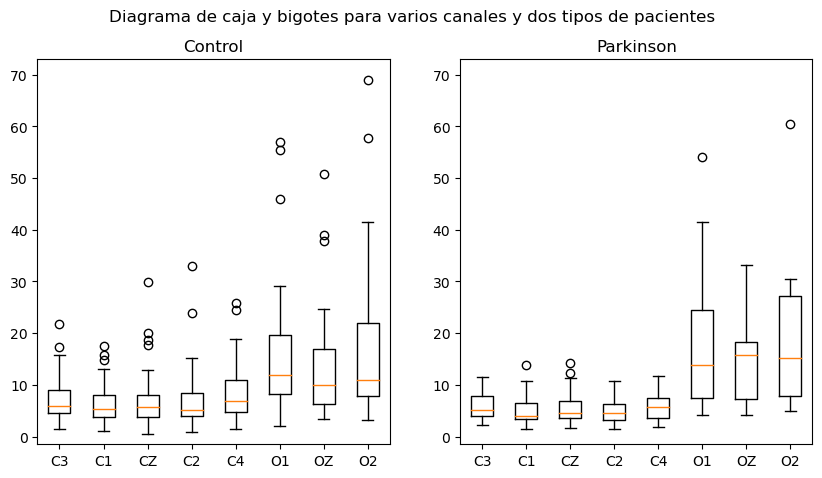

In [80]:
# Crear una lista de dataframes, uno por cada estado
dataframes = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']
labels1=['C3', 'C1', 'CZ', 'C2', 'C4', 'O1', 'OZ', 'O2']
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
    axs[i].set_ylim([-1.5, 73])
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

In [229]:
control, parkinson = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

#Filtrado para control

print("Filtro control:")
control=filtro(control,8,35)
control=filtro(control,7,37)
control=filtro(control,6,40)
control=filtro(control,5,25)
control=filtro(control,4,20)
control=filtro(control,3,25)
#control=filtro(control,2,18)
control=filtro(control,1,20)

#Filtrado para parkinson

print("Filtro Parkinson:")
parkinson=filtro(parkinson,8,50)
parkinson=filtro(parkinson,6,50)
#parkinson=filtro(parkinson,6,30)

Filtro control:
Canal PSD_O2 filtrado
Canal PSD_OZ filtrado
Canal PSD_O1 filtrado
Canal PSD_C4 filtrado
Canal PSD_C2 filtrado
Canal PSD_CZ filtrado
Canal PSD_C3 filtrado
Filtro Parkinson:
Canal PSD_O2 filtrado
Canal PSD_O1 filtrado


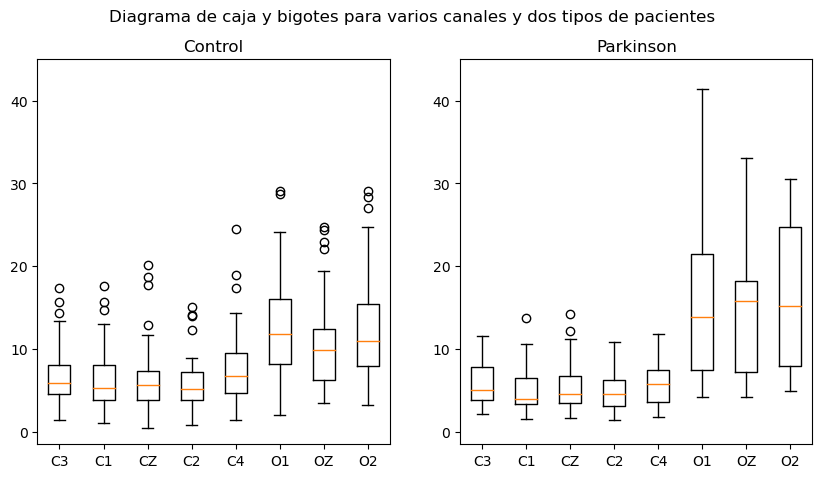

In [230]:
# Crear una lista de dataframes, uno por cada estado
dataframes = control,parkinson

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']
labels1=['C3', 'C1', 'CZ', 'C2', 'C4', 'O1', 'OZ', 'O2']
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
    axs[i].set_ylim([-1.5, 45])
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

In [231]:
dataframes = [control,parkinson]
# Cálculo de la media y la desviación estándar para cada canal
mean_parkinson = dataframes[1].select_dtypes(include=np.number).mean()
std_parkinson = dataframes[1].select_dtypes(include=np.number).std()

mean_control = dataframes[0].select_dtypes(include=np.number).mean()
std_control = dataframes[0].select_dtypes(include=np.number).std()

# Creación del dataframe con los resultados
df_results = pd.DataFrame({
    'Canal': mean_parkinson.index,
    'Media Parkinson': mean_parkinson.values,
    'Desv. Est. Parkinson': std_parkinson.values,
    'Media Control': mean_control.values,
    'Desv. Est. Control': std_control.values,
})

df_results

,Canal,Media Parkinson,Desv. Est. Parkinson,Media Control,Desv. Est. Control
0,PSD_C3,5.974858,2.792382,6.927464,3.882922
1,PSD_C1,5.273632,3.116116,6.325656,4.144918
2,PSD_CZ,5.785000,3.546743,6.687752,4.659058
3,PSD_C2,5.162807,2.800215,5.821198,3.584336
4,PSD_C4,5.954880,2.911959,7.860072,5.039638
5,PSD_O1,15.393061,9.628223,12.805906,6.942512
6,PSD_OZ,14.400776,7.864543,10.994552,5.925249
7,PSD_O2,16.362002,9.270249,12.901913,7.058817


In [232]:
df4=pd.concat(dataframes,ignore_index=True)
df4.to_csv("Datos_filtrados.cvs",index=False)

In [233]:
df4=pd.read_csv("Datos_filtrados.cvs")

In [163]:
names=df4.columns.values
normal={"Estado":"Control"}
pcontrol=sum(df4["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    
    c=df4.loc[0:pcontrol-1,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=[True]
    else:
        normal[i]=[False]
norm=pd.DataFrame.from_dict(normal)

In [164]:
names=df4.columns.values
normal={"Estado":"Parkinson"}
pcontrol=sum(df4["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes parkinson

    c=df4.loc[pcontrol:,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=True
    else:
        normal[i]=False
norm=norm.append(normal,ignore_index=True)
display(norm)


C:\Users\andrt\AppData\Local\Temp\ipykernel_15280\2057974608.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  norm=norm.append(normal,ignore_index=True)


,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
0,Control,False,False,False,False,False,True,True,True
1,Parkinson,True,False,True,True,True,True,True,False


In [166]:
#VERIFICANDO HOMOCEDASTICIDAD
con=0
namesf=[names[6],names[7]]
homo={}
for i in namesf:
  c=df3.loc[0:pcontrol-1,i]
  p=df3.loc[pcontrol:len(df3),i]
  p_valor = levene(c, p).pvalue
  print("Canal %s p=%.3f "% (namesf[con],p_valor))
  if p_valor > 0.05:
    print("Los datos son homocedásticos.")
    homo[namesf[con]]=[True,p_valor]
  else:
    print("Los datos no son homocedásticos.")
    homo[namesf[con]]=[False,p_valor]
  con+=1
print("Homocedásticos")
homocedas=pd.DataFrame.from_dict(homo)
homocedas

Canal PSD_O1 p=0.956 
Los datos son homocedásticos.
Canal PSD_OZ p=0.870 
Los datos son homocedásticos.
Homocedásticos


,PSD_O1,PSD_OZ
0,True,True
1,0.956068,0.869922


In [167]:
con=0
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2']


for i in namesf:
  c=df3.loc[0:pcontrol-1,i]
  p=df3.loc[pcontrol:len(df3),i]
  print("Canal:%s"%namesf[con])
  con+=1
  t=pg.ttest(x=c, y=p, alternative='two-sided', correction=False)
  p=t.loc["T-test","p-val"]
  alpha=0.05
  if p > alpha:
        print('(fail to reject H0)')
  else:
        print('(reject H0)')
  display(t)

Canal:PSD_O1
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.473281,57,two-sided,0.63782,"[-0.49, 0.3]",0.126337,0.296,0.075156


Canal:PSD_OZ
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.777183,57,two-sided,0.440265,"[-0.49, 0.21]",0.20746,0.347,0.119109


# Transformacion de potencia

Se procede a hacer una transformación de potencia de los datos PSD utilizando un logaritmo natural

In [226]:
df3=df.copy()
data=np.log(df3.iloc[:,1:9])
data=data.join(pd.DataFrame(df3.iloc[:,0].values,columns=["Estado"]))
a=list(data.columns)
a[0],a[8]=a[8],a[0]
data=data[a]
data.to_csv("PSD_Tlog.cvs",index=False)

In [227]:
df3=pd.read_csv("PSD_Tlog.cvs")

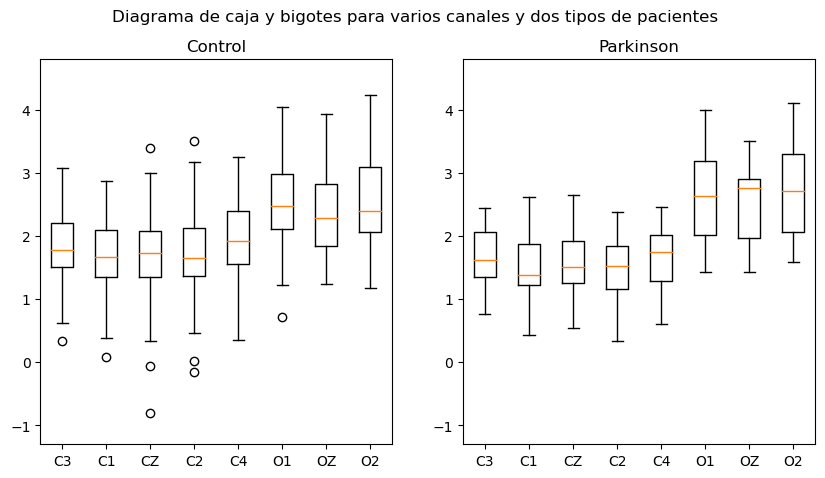

In [187]:
# Crear una lista de dataframes, uno por cada estado
dataframes = [df3[df3['Estado']=='Control'], df3[df3['Estado']=='Parkinson']]

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']
labels1=['C3', 'C1', 'CZ', 'C2', 'C4', 'O1', 'OZ', 'O2']
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
    axs[i].set_ylim([-1.3, 4.8])
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

Se observan diferencias entre las medias de los distintos canales. Se procede a hacer prueba de normalidad ya que con la transformación los datos parecen seguir una distribución normal con menor cantidad de datos atípicos, se procede a hacer un filtrado de estos datos atípicos

# Filtrado datos transformados

In [172]:
df3[df3['Estado']=='Control'].max()

Estado     Control
PSD_C1    2.866945
PSD_CZ    3.398307
PSD_C2    3.498975
PSD_C4    3.251622
PSD_O1    4.044182
PSD_OZ    3.929535
PSD_O2    4.233086
PSD_C3    3.078032
dtype: object

In [170]:
df3[df3['Estado']=='Control'].min()

Estado     Control
PSD_C1     0.08599
PSD_CZ   -0.802776
PSD_C2    -0.15389
PSD_C4    0.356762
PSD_O1    0.713916
PSD_OZ    1.242462
PSD_O2    1.180445
PSD_C3    0.329775
dtype: object

In [234]:
control, parkinson = [df3[df3['Estado']=='Control'], df3[df3['Estado']=='Parkinson']]

#Filtrado para control

print("Filtro control:")
# control=filtro(control,8,35)
# control=filtro(control,7,37)
control=filtro(control,5,1,False)
# control=filtro(control,5,25)
# control=filtro(control,4,20)
control=filtro(control,2,0,False)
control=filtro(control,3,0.2,False)
#control=filtro(control,1,0.1,False)

#Filtrado para parkinson

print("Filtro Parkinson:")
# parkinson=filtro(parkinson,8,50)
# parkinson=filtro(parkinson,7,50)
#parkinson=filtro(parkinson,6,30)
# parkinson=filtro(parkinson,5,50)
#parkinson=filtro(parkinson,4,50)
#parkinson=filtro(parkinson,3,30)
#parkinson=filtro(parkinson,2,50)
#parkinson=filtro(parkinson,1,30)

Filtro control:
Canal PSD_O1 filtrado
Canal PSD_CZ filtrado
Canal PSD_C2 filtrado
Filtro Parkinson:


In [235]:
control.columns

Index(['Estado', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ',
       'PSD_O2', 'PSD_C3'],
      dtype='object')

In [236]:
control.min()

Estado     Control
PSD_C1     0.08599
PSD_CZ    0.333183
PSD_C2     0.46351
PSD_C4    0.356762
PSD_O1    1.217065
PSD_OZ    1.242462
PSD_O2    1.180445
PSD_C3    0.329775
dtype: object

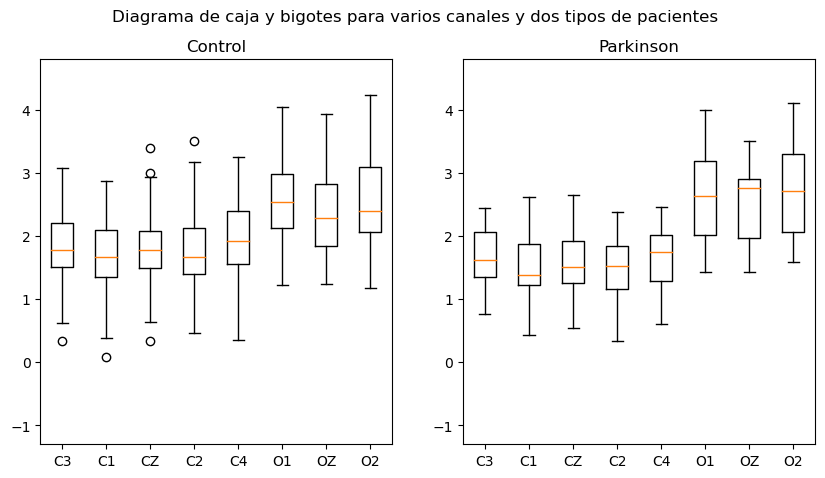

In [237]:
# Crear una lista de dataframes, uno por cada estado
dataframes = control, parkinson

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']
labels1=['C3', 'C1', 'CZ', 'C2', 'C4', 'O1', 'OZ', 'O2']
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
    axs[i].set_ylim([-1.3, 4.8])
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

In [238]:
df5=pd.concat(dataframes,ignore_index=True)
df5.to_csv("Datos_filtrados_T.cvs",index=False)

In [239]:
df5=pd.read_csv("Datos_filtrados_T.cvs")

Media y desviación estandar datos sin transformar

In [240]:
dataframes = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]
# Cálculo de la media y la desviación estándar para cada canal
mean_parkinson = dataframes[1].select_dtypes(include=np.number).mean()
std_parkinson = dataframes[1].select_dtypes(include=np.number).std()

mean_control = dataframes[0].select_dtypes(include=np.number).mean()
std_control = dataframes[0].select_dtypes(include=np.number).std()

# Creación del dataframe con los resultados
df_results = pd.DataFrame({
    'Canal': mean_parkinson.index,
    'Media Parkinson': mean_parkinson.values,
    'Desv. Est. Parkinson': std_parkinson.values,
    'Media Control': mean_control.values,
    'Desv. Est. Control': std_control.values,
})

df_results

,Canal,Media Parkinson,Desv. Est. Parkinson,Media Control,Desv. Est. Control
0,PSD_C3,5.974858,2.792382,7.338246,4.599109
1,PSD_C1,5.273632,3.116116,6.325656,4.144918
2,PSD_CZ,5.785000,3.546743,7.332909,6.057312
3,PSD_C2,5.162807,2.800215,7.080957,6.465159
4,PSD_C4,5.954880,2.911959,8.359298,5.862602
5,PSD_O1,17.075360,12.561674,16.138638,13.264496
6,PSD_OZ,14.400776,7.864543,13.624426,10.786595
7,PSD_O2,18.281925,13.065904,16.496742,14.384994


Media y desviación estandar de datos transformados

In [241]:
dataframes = [df3[df3['Estado']=='Control'], df3[df3['Estado']=='Parkinson']]
# Cálculo de la media y la desviación estándar para cada canal
mean_parkinson = dataframes[1].select_dtypes(include=np.number).mean()
std_parkinson = dataframes[1].select_dtypes(include=np.number).std()

mean_control = dataframes[0].select_dtypes(include=np.number).mean()
std_control = dataframes[0].select_dtypes(include=np.number).std()

# Creación del dataframe con los resultados
df_results = pd.DataFrame({
    'Canal': mean_parkinson.index,
    'Media Parkinson': mean_parkinson.values,
    'Desv. Est. Parkinson': std_parkinson.values,
    'Media Control': mean_control.values,
    'Desv. Est. Control': std_control.values,
})

df_results

,Canal,Media Parkinson,Desv. Est. Parkinson,Media Control,Desv. Est. Control
0,PSD_C1,1.507460,0.571795,1.635518,0.681486
1,PSD_CZ,1.582203,0.606798,1.694335,0.836500
2,PSD_C2,1.494895,0.569915,1.652363,0.793524
3,PSD_C4,1.658850,0.530266,1.902594,0.688935
4,PSD_O1,2.600104,0.705907,2.507166,0.753733
5,PSD_OZ,2.506420,0.604488,2.370492,0.685161
6,PSD_O2,2.678920,0.692243,2.538031,0.703679
7,PSD_C3,1.683799,0.468480,1.814637,0.617434


Como puede observarse, la desviación estandar mejoró con respecto a los datos sin la transformación de potencia con el logaritmo natural, sin embargo esto claramente afecta la media de los datos

In [242]:
names=df3.columns.values
normal={"Estado":"Control"}
pcontrol=sum(df3["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    
    c=df3.loc[0:pcontrol-1,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=[True]
    else:
        normal[i]=[False]
norm=pd.DataFrame.from_dict(normal)

In [243]:
names=df3.columns.values
normal={"Estado":"Parkinson"}
pcontrol=sum(df3["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes parkinson

    c=df3.loc[pcontrol:,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=True
    else:
        normal[i]=False
norm=norm.append(normal,ignore_index=True)


C:\Users\andrt\AppData\Local\Temp\ipykernel_15280\3919779954.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  norm=norm.append(normal,ignore_index=True)


In [244]:
norm

,Estado,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2,PSD_C3
0,Control,True,True,True,True,True,True,True,True
1,Parkinson,True,True,True,True,True,True,True,True


In [245]:
#VERIFICANDO HOMOCEDASTICIDAD
con=0

homo={}
for i in names[1:]:
  c=df3.loc[0:pcontrol-1,i]
  p=df3.loc[pcontrol:len(df3),i]
  p_valor = levene(c, p).pvalue
  print("Canal %s p=%.3f "% (names[con],p_valor))
  if p_valor > 0.05:
    print("Los datos son homocedásticos.")
    homo[names[con]]=[True,p_valor]
  else:
    print("Los datos no son homocedásticos.")
    homo[names[con]]=[False,p_valor]
  con+=1
print("Homocedásticos")
homocedas=pd.DataFrame.from_dict(homo)
homocedas

Canal Estado p=0.475 
Los datos son homocedásticos.
Canal PSD_C1 p=0.478 
Los datos son homocedásticos.
Canal PSD_CZ p=0.276 
Los datos son homocedásticos.
Canal PSD_C2 p=0.293 
Los datos son homocedásticos.
Canal PSD_C4 p=0.956 
Los datos son homocedásticos.
Canal PSD_O1 p=0.870 
Los datos son homocedásticos.
Canal PSD_OZ p=0.644 
Los datos son homocedásticos.
Canal PSD_O2 p=0.423 
Los datos son homocedásticos.
Homocedásticos


,Estado,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
0,True,True,True,True,True,True,True,True
1,0.474665,0.477622,0.275556,0.292699,0.956068,0.869922,0.643848,0.423004


La hipótesis nula H0 de la prueba t es que no hay diferencia significativa entre las medias de dos muestras.

In [246]:
con=0
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2']

namest=names[1:]
for i in namest:
  c=df3.loc[0:pcontrol-1,i]
  p=df3.loc[pcontrol:len(df3),i]
  print("Canal:%s"%namest[con])
  con+=1
  t=pg.ttest(x=c, y=p, alternative='two-sided', correction=False)
  p=t.loc["T-test","p-val"]
  alpha=0.05
  if p > alpha:
        print('(fail to reject H0)')
  else:
        print('(reject H0)')
  display(t)

Canal:PSD_C3
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.868096,57,two-sided,0.388982,"[-0.17, 0.43]",0.231728,0.369,0.136721


Canal:PSD_C1
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.747972,57,two-sided,0.457552,"[-0.21, 0.47]",0.199662,0.34,0.113891


Canal:PSD_CZ
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.555531,57,two-sided,0.580706,"[-0.29, 0.52]",0.148292,0.307,0.084821


Canal:PSD_C2
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.824413,57,two-sided,0.413142,"[-0.23, 0.54]",0.220067,0.358,0.127999


Canal:PSD_C4
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.443818,57,two-sided,0.154264,"[-0.09, 0.58]",0.38541,0.639,0.294812


Canal:PSD_O1
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.473281,57,two-sided,0.63782,"[-0.49, 0.3]",0.126337,0.296,0.075156


Canal:PSD_OZ
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.777183,57,two-sided,0.440265,"[-0.49, 0.21]",0.20746,0.347,0.119109


Canal:PSD_O2
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.754759,57,two-sided,0.453501,"[-0.51, 0.23]",0.201474,0.342,0.115084


En este caso ni utilizando un nivel de significacia del 10 % se rechaza la hipotesis nula para ninguno de los canales

---

# Estadistica Inferencial datos transformados y filtrados

In [248]:
df5=pd.read_csv("Datos_filtrados_T.cvs")

In [249]:
names=df5.columns.values
normal={"Estado":"Control"}
pcontrol=sum(df5["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    
    c=df5.loc[0:pcontrol-1,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=[True]
    else:
        normal[i]=[False]
norm=pd.DataFrame.from_dict(normal)

In [250]:
names=df5.columns.values
normal={"Estado":"Parkinson"}
pcontrol=sum(df5["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes parkinson

    c=df5.loc[pcontrol:,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=True
    else:
        normal[i]=False
norm=norm.append(normal,ignore_index=True)


C:\Users\andrt\AppData\Local\Temp\ipykernel_15280\1781157641.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  norm=norm.append(normal,ignore_index=True)


In [251]:
norm

,Estado,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2,PSD_C3
0,Control,True,True,True,True,True,True,True,True
1,Parkinson,True,True,True,True,True,True,True,True


In [252]:
#VERIFICANDO HOMOCEDASTICIDAD
con=0

homo={}
for i in names[1:]:
  c=df5.loc[0:pcontrol-1,i]
  p=df5.loc[pcontrol:len(df5),i]
  p_valor = levene(c, p).pvalue
  print("Canal %s p=%.3f "% (names[con],p_valor))
  if p_valor > 0.05:
    print("Los datos son homocedásticos.")
    homo[names[con]]=[True,p_valor]
  else:
    print("Los datos no son homocedásticos.")
    homo[names[con]]=[False,p_valor]
  con+=1
print("Homocedásticos")
homocedas=pd.DataFrame.from_dict(homo)
homocedas

Canal Estado p=0.475 
Los datos son homocedásticos.
Canal PSD_C1 p=0.874 
Los datos son homocedásticos.
Canal PSD_CZ p=0.673 
Los datos son homocedásticos.
Canal PSD_C2 p=0.293 
Los datos son homocedásticos.
Canal PSD_C4 p=0.604 
Los datos son homocedásticos.
Canal PSD_O1 p=0.870 
Los datos son homocedásticos.
Canal PSD_OZ p=0.644 
Los datos son homocedásticos.
Canal PSD_O2 p=0.423 
Los datos son homocedásticos.
Homocedásticos


,Estado,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
0,True,True,True,True,True,True,True,True
1,0.474665,0.873853,0.673284,0.292699,0.604079,0.869922,0.643848,0.423004


La hipótesis nula H0 de la prueba t es que no hay diferencia significativa entre las medias de dos muestras.

In [253]:
con=0
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2']

namest=names[1:]
for i in namest:
  c=df5.loc[0:pcontrol-1,i]
  p=df5.loc[pcontrol:len(df5),i]
  print("Canal:%s"%namest[con])
  con+=1
  t=pg.ttest(x=c, y=p, alternative='two-sided', correction=False)
  p=t.loc["T-test","p-val"]
  alpha=0.05
  if p > alpha:
        print('(fail to reject H0)')
  else:
        print('(reject H0)')
  display(t)

Canal:PSD_C3
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.868096,57,two-sided,0.388982,"[-0.17, 0.43]",0.231728,0.369,0.136721


Canal:PSD_C1
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.747972,57,two-sided,0.457552,"[-0.21, 0.47]",0.199662,0.34,0.113891


Canal:PSD_CZ
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.406225,57,two-sided,0.165086,"[-0.1, 0.57]",0.375375,0.611,0.282253


Canal:PSD_C2
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.526339,57,two-sided,0.132456,"[-0.08, 0.6]",0.407438,0.706,0.323274


Canal:PSD_C4
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.443818,57,two-sided,0.154264,"[-0.09, 0.58]",0.38541,0.639,0.294812


Canal:PSD_O1
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.224761,57,two-sided,0.822969,"[-0.41, 0.33]",0.059997,0.275,0.055614


Canal:PSD_OZ
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.777183,57,two-sided,0.440265,"[-0.49, 0.21]",0.20746,0.347,0.119109


Canal:PSD_O2
(fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.754759,57,two-sided,0.453501,"[-0.51, 0.23]",0.201474,0.342,0.115084


---

# Estadistica descriptiva Coherencia

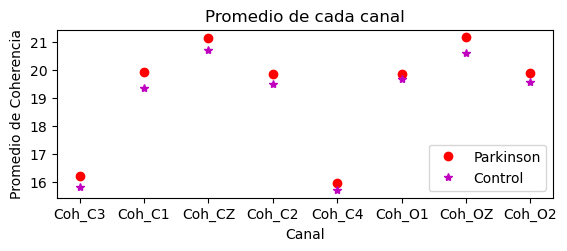

In [49]:
control,parkinson = [df2[df2['Estado']=='Control'], df2[df2['Estado']=='Parkinson']]
prom=[]
for i in control.columns[1:]:
    prom.append(control[i].mean())
promcontrol=pd.DataFrame(columns=control.columns[1:].to_list())
promcontrol.loc[0]=prom
prom=[]
for i in parkinson.columns[1:]:
    prom.append(parkinson[i].mean())
promparkinson=pd.DataFrame(columns=parkinson.columns[1:].to_list())
promparkinson.loc[0]=prom
plt.subplot(2,1,1)
plt.plot(promparkinson.loc[0], "or", linewidth='1',label="Parkinson" )
plt.plot(promcontrol.loc[0],"*m" , linewidth='1',label="Control" )
plt.title("Promedio de cada canal")
plt.ylabel("Promedio de Coherencia")
plt.xlabel("Canal")
plt.legend()

Se puede notar una diferencia entre los promedios de la sumatoria de la coherencia para las frecuecias de 13 a 30 Hz de los diferentes canales en pacientes parkinson y los pacientes control pero no se sabe si esta diferencia es significativa

Se procede a visualizar la distribución utilizando histogramas

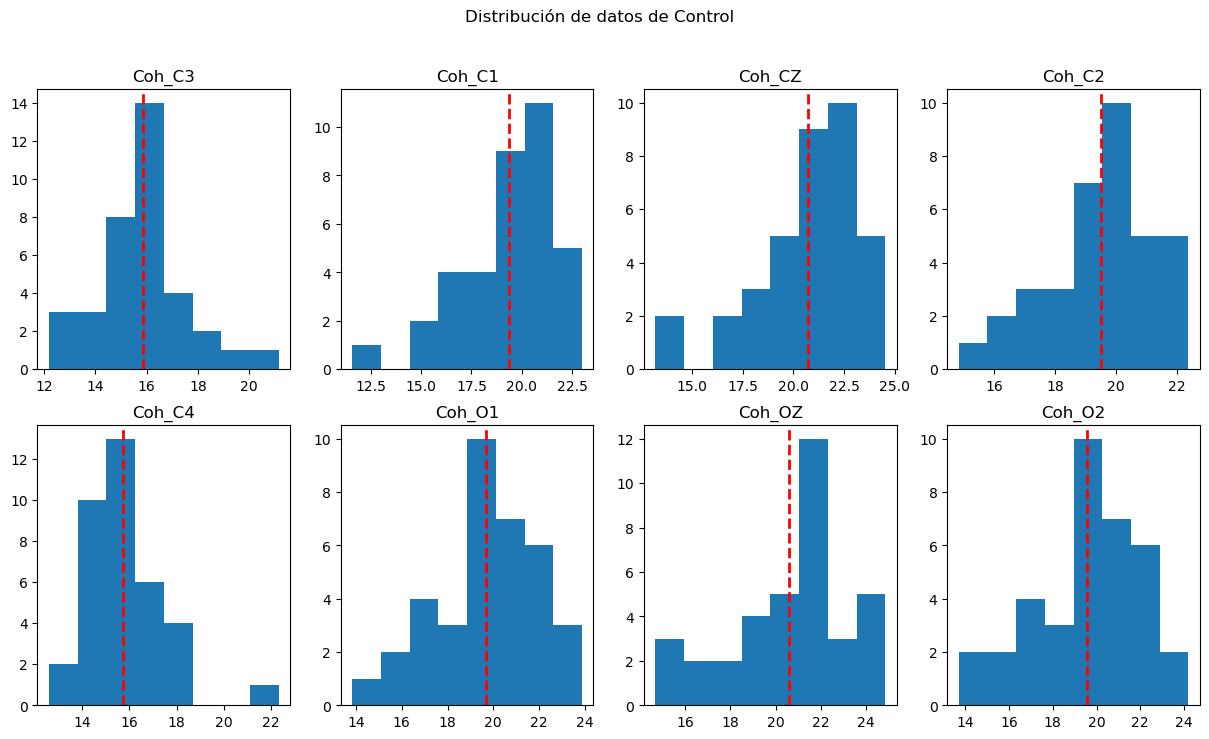

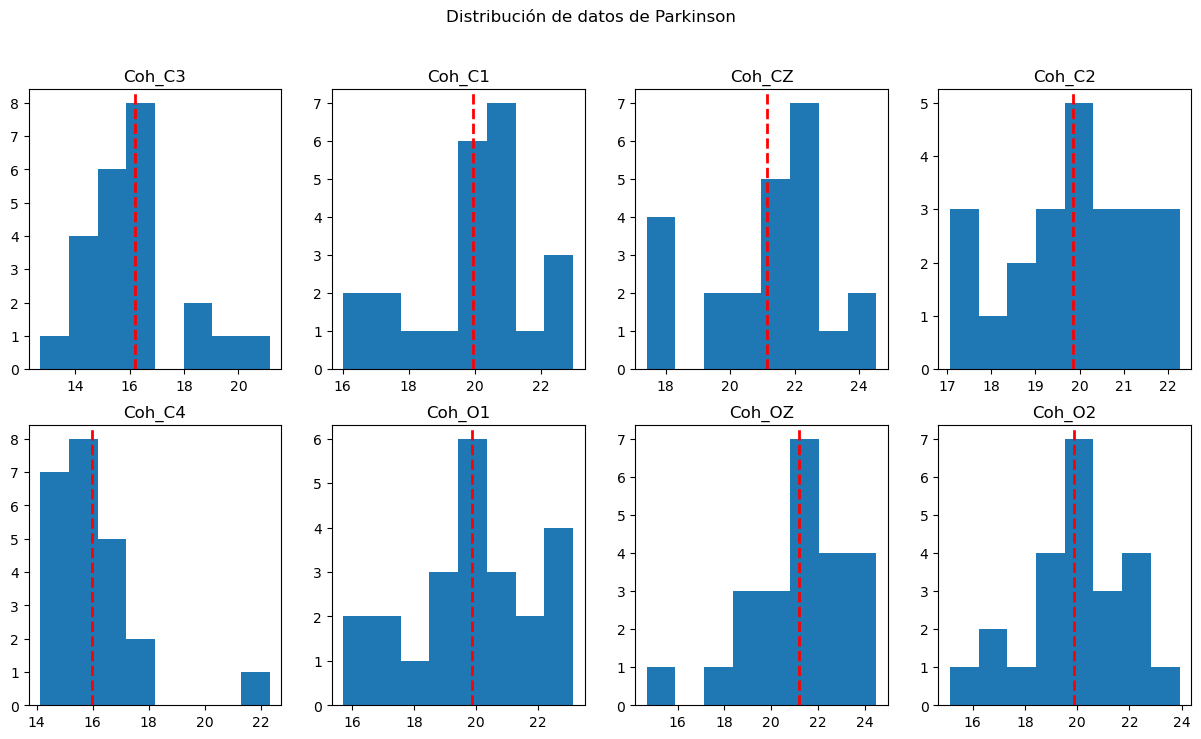

In [50]:
control,parkinson = [df2[df2['Estado']=='Control'], df2[df2['Estado']=='Parkinson']]
parkinson=parkinson.reset_index(drop=True)
names=control.columns
grafhist(control)
grafhist(parkinson)

En este caso si se nota una distribución más similar a una distribución normal en la mayoría de los casos, sin embargo hace falta más evidencia para concluir sobre la distribución

Se procede a visualizar mejor los datos con un diagrama de caja y bigotes el cual contiene la información de los gráficos anteriores y muestra la desviación

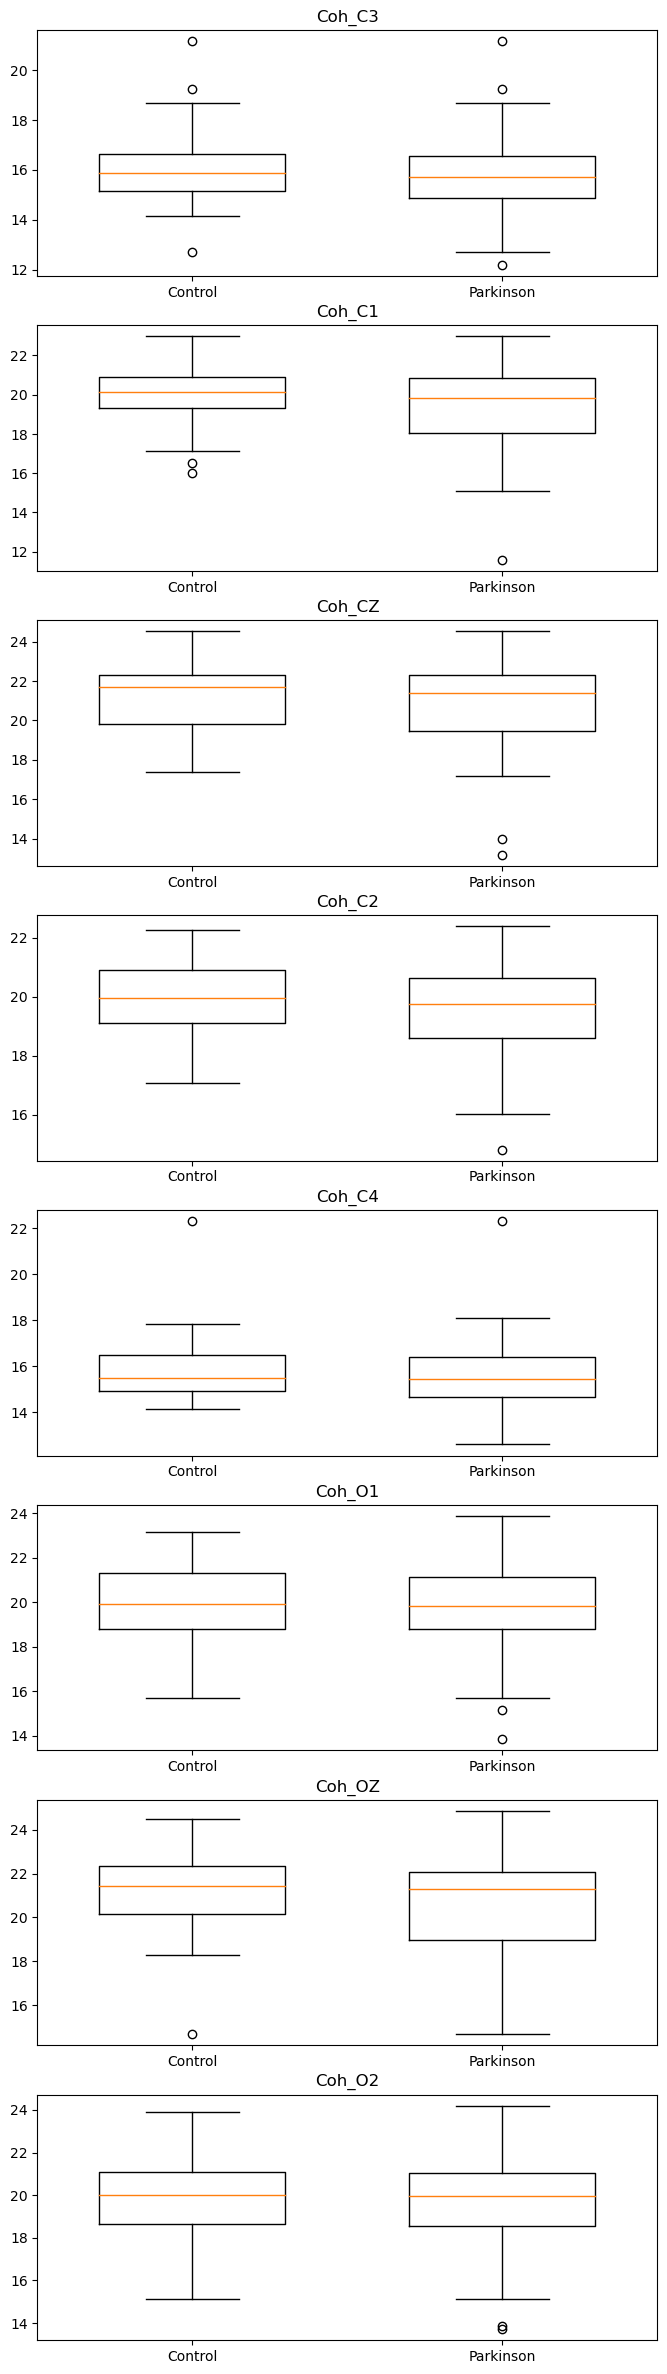

In [51]:
canales = ['Coh_C3', 'Coh_C1', 'Coh_CZ', 'Coh_C2', 'Coh_C4', 'Coh_O1', 'Coh_OZ', 'Coh_O2']

fig, axs = plt.subplots(len(canales), 1, figsize=(8, 30))

for i, canal in enumerate(canales):
    for estado in df2['Estado'].unique():
        datos_canal_estado = df2.loc[df2['Estado'] == estado, canal]
        axs[i].boxplot(datos_canal_estado, positions=[0 if estado == 'Parkinson' else 1], widths=0.6)
        
        axs[i].set_title(canal)
    axs[i].set_xticklabels(['Parkinson', 'Control'])
plt.show()

Se observa que los canales llevan una distribución similar con diferencias en algunos datos atípicos y con medias similares

In [52]:
dataframes = [df2[df2['Estado']=='Control'], df2[df2['Estado']=='Parkinson']]
# Cálculo de la media y la desviación estándar para cada canal
mean_parkinson = dataframes[1].select_dtypes(include=np.number).mean()
std_parkinson = dataframes[1].select_dtypes(include=np.number).std()

mean_control = dataframes[0].select_dtypes(include=np.number).mean()
std_control = dataframes[0].select_dtypes(include=np.number).std()

# Creación del dataframe con los resultados
df_results = pd.DataFrame({
    'Canal': mean_parkinson.index,
    'Media Parkinson': mean_parkinson.values,
    'Desv. Est. Parkinson': std_parkinson.values,
    'Media Control': mean_control.values,
    'Desv. Est. Control': std_control.values,
})

df_results

,Canal,Media Parkinson,Desv. Est. Parkinson,Media Control,Desv. Est. Control
0,Coh_C3,16.211664,1.835919,15.842516,1.775152
1,Coh_C1,19.947629,1.888070,19.377301,2.458386
2,Coh_CZ,21.131273,2.070638,20.718802,2.640267
3,Coh_C2,19.842203,1.502295,19.500073,1.804493
4,Coh_C4,15.973306,1.714068,15.722223,1.667067
5,Coh_O1,19.863618,2.073120,19.673049,2.311615
6,Coh_OZ,21.172059,2.247595,20.616150,2.657785
7,Coh_O2,19.888076,2.043343,19.559963,2.526136


Se tienen pocas variaciones en las medias de los datos y unas desviaciones estandar mayores a 1 que se considera relativamente alta, e incluso en algunos casos mayor a 2 que es muy alta

---

# Estadistica inferencial Coherencia

In [53]:
names=df2.columns.values
normal={"Estado":"Control"}
pcontrol=sum(df2["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    
    c=df2.loc[0:pcontrol-1,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=[True]
    else:
        normal[i]=[False]
norm=pd.DataFrame.from_dict(normal)

In [54]:
names=df2.columns.values
normal={"Estado":"Parkinson"}
pcontrol=sum(df2["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes parkinson

    c=df2.loc[pcontrol:,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=True
    else:
        normal[i]=False
norm=norm.append(normal,ignore_index=True)


C:\Users\andrt\AppData\Local\Temp\ipykernel_15280\3661681433.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  norm=norm.append(normal,ignore_index=True)


In [55]:
norm

,Estado,Coh_C3,Coh_C1,Coh_CZ,Coh_C2,Coh_C4,Coh_O1,Coh_OZ,Coh_O2
0,Control,True,False,False,True,False,True,True,True
1,Parkinson,True,True,True,True,False,True,True,True


Se procede a verificar la Homocedasticidad de los datos utilizando la prueba de Levene. El resultado de la prueba de Levene se puede utilizar para decidir si la prueba t de dos muestras se deben realizar utilizando una suposición de igualdad de varianzas entre los grupos para así obtener resultados más conficables. En este caso la hipótesis nula es que los grupos de datos tienen variazas iguales (son homocedásticos)

In [56]:
#VERIFICANDO HOMOCEDASTICIDAD
con=0
namest=[names[1],names[4],names[6],names[7],names[8]]
homo={}
for i in namest:
  c=df2.loc[0:pcontrol-1,i]
  p=df2.loc[pcontrol:len(df2),i]
  p_valor = levene(c, p).pvalue
  print("Canal %s p=%.3f "% (namest[con],p_valor))
  if p_valor > 0.05:
    print("Los datos son homocedásticos.")
    homo[namest[con]]=[True,p_valor]
  else:
    print("Los datos no son homocedásticos.")
    homo[namest[con]]=[False,p_valor]
  con+=1
print("Homocedásticos")
homocedas=pd.DataFrame.from_dict(homo)
homocedas

Canal Coh_C3 p=0.938 
Los datos son homocedásticos.
Canal Coh_C2 p=0.460 
Los datos son homocedásticos.
Canal Coh_O1 p=0.743 
Los datos son homocedásticos.
Canal Coh_OZ p=0.382 
Los datos son homocedásticos.
Canal Coh_O2 p=0.421 
Los datos son homocedásticos.
Homocedásticos


,Coh_C3,Coh_C2,Coh_O1,Coh_OZ,Coh_O2
0,True,True,True,True,True
1,0.937812,0.460268,0.742746,0.381744,0.420589


No se rechaza la hipótesis nula lo que quiere decir que los grupos de datos son homocedásticos. Se procede a realizar la prueba T con los canales que tienen distribución normal y son homocedásticos

In [57]:
con=0
for i in namest:
  c=df2.loc[0:pcontrol-1,i]
  p=df2.loc[pcontrol:len(df2),i]
  print("Canal:%s"%namest[con])
  con+=1
  t=pg.ttest(x=c, y=p, alternative='two-sided', correction=False)
  p=t.loc["T-test","p-val"]
  alpha=0.05
  if p > alpha:
        print('Same distribution (fail to reject H0)')
  else:
        print('Different distribution (reject H0)')
  display(t)

Canal:Coh_C3
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.768768,57,two-sided,0.445205,"[-1.33, 0.59]",0.205214,0.345,0.117584


Canal:Coh_C2
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.756487,57,two-sided,0.452473,"[-1.25, 0.56]",0.201935,0.342,0.11539


Canal:Coh_O1
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.321203,57,two-sided,0.749231,"[-1.38, 1.0]",0.085741,0.282,0.061503


Canal:Coh_OZ
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.830546,57,two-sided,0.409695,"[-1.9, 0.78]",0.221705,0.359,0.129194


Canal:Coh_O2
Same distribution (fail to reject H0)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.522702,57,two-sided,0.603208,"[-1.59, 0.93]",0.139529,0.302,0.080768


Se tienen Valores de p muy altos lo que indica la poca probabilidad de que se cumpla la hipótesis alternativa

Se procede a realizar la prueba U para los canales que no cumplieron con el supuesto de normalidad.

In [58]:
namest=[names[2],names[3],names[5]]

stat, p = mannwhitneyu(control[namest],parkinson[namest])
con=0
for i in p: 
    print('Statistics=%.3f, p=%.3f for channel %s' % (stat[con], i,namest[con]))
    con+=1
    #interpret
    alpha = 0.05
    if i > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')


Statistics=365.500, p=0.456 for channel Coh_C1
Same distribution (fail to reject H0)
Statistics=386.500, p=0.675 for channel Coh_CZ
Same distribution (fail to reject H0)
Statistics=382.500, p=0.630 for channel Coh_C4
Same distribution (fail to reject H0)


Misma situación que la de arriba